In [1]:
################################################################################
### Python port of rlasso.R
### https://github.com/cran/hdm/blob/master/R/rlasso.R
################################################################################

################################################################################
### 1: Load modules
################################################################################

# Standard Python modules
import joblib as jbl
import multiprocess as mp
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression as lm

# Other parts of hdmpy
from hdmpy.help_functions import cvec, init_values
from hdmpy.LassoShooting_fit import LassoShooting_fit

In [2]:
################################################################################
### 2: Define functions
################################################################################

################################################################################
### 2.1: Functions which are not in the original R package
###      These are generally helper functions to allow an implementation which
###      reads as closely to the original R code as possible, and to ease a
###      Python implementation, including parallelizing the code
################################################################################


# Define a function to simulate distributions needed for calculating X-dependent
# penalty terms
def simul_pen(n, p, W, seed=0, fix_seed=True):
    # Check whether the seed needs to be fixed
    if fix_seed:
        # Simulate with provided seed
        g = norm.rvs(size=(n,1), random_state=seed) @ np.ones(shape=(1,p))
    else:
        # Simulate using whatever state the RNG is currently in
        g = norm.rvs(size=(n,1)) @ np.ones(shape=(1,p))

    # Calculate element of the distribution for the current draw of g
    s = n * np.amax(2 * np.abs(np.mean(W * g, axis=0)))

    # Return the result
    return s

In [3]:
################################################################################
### 2.2: Functions which are in the original R package
################################################################################


def lambdaCalculation(homoskedastic=False, X_dependent_lambda=False,
                      lambda_start=None, c=1.1, gamma=0.1, numSim=5000, y=None,
                      x=None, par=True, corecap=np.inf, fix_seed=True):
    # Get number of observations n and number of variables p
    n, p = x.shape

    # Get number of simulations to use (if simulations are necessary)
    R = numSim

    # Go through all possible combinations of homoskedasticy/heteroskedasticity
    # and X-dependent or independent error terms. The first two cases are
    # special cases: Handling the case there homoskedastic was set to None, and
    # where lambda_start was provided.
    #
    # 1) If homoskedastic was set to None (special case)
    if homoskedastic is None:
        # Initialize lambda
        lmbda0 = lambda_start

        Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T

        # Calculate the final vector of penalty terms
        lmbda = lmbda0 * Ups0

    # 2) If lambda_start was provided (special case)
    elif lambda_start is not None:
        # Check whether a homogeneous penalty term was provided (a scalar)
        if np.amax(cvec(lambda_start).shape) == 1:
            # If so, repeat that p times as the penalty term
            lmbda = np.ones(shape=(p,1)) * lambda_start
        else:
            # Otherwise, use the provided vector of penalty terms as is
            lmbda = lambda_start

    # 3) Homoskedastic and X-independent
    elif (homoskedastic == True) and (X_dependent_lambda == False):
        # Initilaize lambda
        lmbda0 = 2 * c * np.sqrt(n) * norm.ppf(1 - gamma/(2*p))

        # Use ddof=1 to be consistent with R's var() function
        Ups0 = np.sqrt(np.var(y, axis=0, ddof=1))

        # Calculate the final vector of penalty terms
        lmbda = np.zeros(shape=(p,1)) + lmbda0 * Ups0

    # 4) Homoskedastic and X-dependent
    elif (homoskedastic == True) and (X_dependent_lambda == True):
        psi = cvec((x**2).mean(axis=0))

        tXtpsi = (x.T / np.sqrt(psi)).T

        # Check whether to use parallel processing
        if par == True:
            # If so, get the number of cores to use
            cores = np.int(np.amin([mp.cpu_count(), corecap]))
        else:
            # Otherwise, use only one core (i.e. run sequentially)
            cores = 1

        # Get simulated distribution
        sim = jbl.Parallel(n_jobs=cores)(
            jbl.delayed(simul_pen)(
                n, p, tXtpsi, seed=l*20, fix_seed=fix_seed
            ) for l in np.arange(R)
        )

        # Convert it to a proper column vector
        sim = cvec(sim)

        # Initialize lambda based on the simulated quantiles
        lmbda0 = c * np.quantile(sim, q=1-gamma, axis=0)

        Ups0 = np.sqrt(np.var(y, axis=0, ddof=1))

        # Calculate the final vector of penalty terms
        lmbda = np.zeros(shape=(p,1)) + lmbda0 * Ups0

    # 5) Heteroskedastic and X-independent
    elif (homoskedastic == False) and (X_dependent_lambda == False):
        # The original includes the comment, "1=num endogenous variables"
        lmbda0 = 2 * c * np.sqrt(n) * norm.ppf(1 - gamma/(2*p*1))

        Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T

        lmbda = lmbda0 * Ups0

    # 6) Heteroskedastic and X-dependent
    elif (homoskedastic == False) and (X_dependent_lambda == True):
        eh = y

        ehat = eh @ np.ones(shape=(1,p))

        xehat = x * ehat

        psi = cvec((xehat**2).mean(axis=0)).T

        tXehattpsi = (xehat / ( np.ones(shape=(n,1)) @ np.sqrt(psi) ))

        # Check whether to use parallel processing
        if par == True:
            # If so, get the number of cores to use
            cores = np.int(np.amin([mp.cpu_count(), corecap]))
        else:
            # Otherwise, use only one core (i.e. run sequentially)
            cores = 1

        # Get simulated distribution
        sim = jbl.Parallel(n_jobs=cores)(
            jbl.delayed(simul_pen)(
                n, p, tXehattpsi, seed=l*20, fix_seed=fix_seed
            ) for l in np.arange(R)
        )

        # Convert it to a proper column vector
        sim = cvec(sim)

        # Initialize lambda based on the simulated quantiles
        lmbda0 = c * np.quantile(sim, q=1-gamma, axis=0)

        Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T

        # Calculate the final vector of penalty terms
        lmbda = lmbda0 * Ups0

    # Return results
    return {'lambda0': lmbda0, 'lambda': lmbda, 'Ups0': Ups0}

In [51]:
import numpy as np
import random
import statsmodels.api as sm
# Set Seed
random.seed(10)
print(random.random())

n = 10
p = n//2
x = np.random.normal(0, 1, size=(n, p))
y = np.random.normal(0, 1,n)
beta = np.random.normal(0, 1,n)
lmbda = np.random.normal(0, 1,n)
gamma = 0.1

0.5714025946899135


In [65]:
eh = y

ehat = eh @ np.ones(shape=(1,p))

xehat = x * ehat
psi = cvec((x**2).mean(axis=0)).T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 10)

In [74]:
a = x**2
a.shape
a

array([[2.34724855e+00, 1.36356347e+00, 1.66189173e-01, 2.43429083e-01,
        1.24474439e-01],
       [5.18480261e-01, 1.01976076e+00, 4.90345817e-01, 1.19571643e+00,
        1.21579329e-01],
       [2.35859450e+00, 3.31353285e-01, 1.22411472e+00, 1.62233802e-01,
        8.59500523e-03],
       [2.79668010e+00, 1.55676322e+00, 1.74243937e-01, 3.74456482e-01,
        7.07361957e-01],
       [2.42399123e+00, 1.21865079e+00, 1.34357160e+00, 2.29378517e-01,
        1.28580135e+00],
       [2.68158478e-04, 5.98564374e-02, 2.31068255e-01, 1.69459892e+00,
        2.56037183e-03],
       [1.47232806e-02, 6.82367293e-03, 4.92728420e-01, 2.68761196e+00,
        4.44376419e-01],
       [2.07423209e-03, 1.95706270e-01, 1.15283212e+00, 3.27670432e-01,
        8.67918348e-01],
       [2.04074501e+00, 8.00075899e-01, 6.73538133e-02, 1.97217549e+00,
        1.24392572e+00],
       [2.09500055e-02, 1.44509447e-01, 1.98782585e+00, 2.42599422e-01,
        7.94955236e-01]])

In [67]:
psi = cvec((x**2).mean(axis=0)).T
psi

array([[1.25237553, 0.66970632, 0.73302737, 0.91298705, 0.56015482]])

In [61]:
y.T@np.ones(shape=(1,p))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 10)

In [63]:
np.ones(shape=(1,p)).shape

(1, 5)

In [55]:
eh = y

ehat = eh @ np.ones(shape=(1,p))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 10)

In [33]:
Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T
Ups0 

array([0.81457888, 0.65552213, 0.60191268, 0.57792912, 0.4829452 ])

In [48]:
(y**2).T

array([0.49171182, 0.94548481, 0.01558194, 1.84153318, 0.84980063,
       3.00381569, 1.99125034, 0.16976616, 1.14532861, 0.43418689])

In [49]:
(x**2)

array([[6.15788567e+00, 2.55424923e-01, 3.40205674e-01, 1.00682747e-01,
        1.68222923e-02],
       [8.00701969e-03, 1.25809884e-02, 1.54341064e+00, 6.75475165e-04,
        9.10582869e-02],
       [1.93417152e-03, 1.70433556e+00, 6.48904756e-02, 1.14931201e-01,
        1.01984279e+00],
       [6.59905614e-02, 3.35087475e-03, 1.13937828e-01, 1.57711249e+00,
        6.71238125e-02],
       [1.98694748e+00, 5.81559443e-02, 4.71941855e-01, 1.18352967e-02,
        1.18606333e+00],
       [1.10453769e-01, 3.30866043e-01, 1.89609280e-01, 4.24622093e-02,
        2.61452307e-03],
       [3.94392899e-02, 2.69787922e-01, 1.50322613e-01, 4.33688332e-04,
        4.53770598e-04],
       [2.25404625e+00, 7.67283484e-01, 3.63627244e-01, 1.07145069e-01,
        1.57573180e+00],
       [5.97077619e-01, 3.37930771e-01, 2.04918178e-01, 1.24099439e-01,
        1.19920320e-01],
       [7.20937188e-01, 4.67328041e+00, 5.04931981e-01, 1.95734138e-01,
        1.55915405e+00]])

In [38]:
(y**2).T@ (x**2)

array([6.63538744, 4.29709269, 3.62298875, 3.34002071, 2.33236064])

In [31]:
Ups0 = np.sqrt(np.var(y, axis=0, ddof=1))
Ups0

0.9919856597827262

In [27]:
norm.ppf(1 - gamma/(2*p))

2.3263478740408408

In [16]:
from scipy.stats import norm
import matplotlib.pyplot as plt

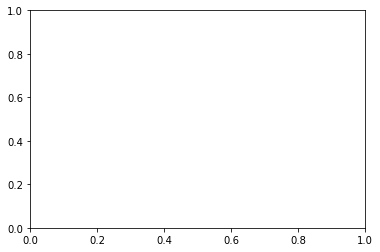

In [18]:
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = norm.stats(moments='mvsk')

In [23]:
rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [24]:
norm.ppf(0.95, loc=0, scale=1)

1.6448536269514722

In [8]:
Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T
Ups0

array([0.72570517, 0.46446458, 0.83128209, 1.036849  , 1.09542523])

In [4]:
class MyClass(object):

    def __init__(self, foo, bar):
        self.foo = foo
        self.bar = bar

    def do_something(self):
        return self.foo + self.bar

    def do_something_else(self, num):
        return num * self.bar


my_class = MyClass(1, 10)
my_class.do_something()  # returns 11
my_class.do_something_else(10)  # returns 100


100

In [1]:
################################################################################
### 3: Define classes
################################################################################

class rlasso:
    # Initialize gamma to None to get gamma=.1/log(n)
    def __init__(self, x, y, colnames=None, post=True, intercept=True,
                 model=True, homoskedastic=False, X_dependent_lambda=False,
                 lambda_start=None, c=1.1, gamma=None, numSim=5000, numIter=15,
                 tol=10**(-5), threshold=-np.inf, par=True, corecap=np.inf,
                 fix_seed=True):
        # Initialize internal variables
        if isinstance(x, pd.DataFrame) and colnames is None:
            colnames = x.columns

        self.x = np.array(x).astype(np.float32)
        self.y = cvec(y).astype(np.float32)

        self.n, self.p = self.x.shape

        if colnames is None:
            self.colnames = ['V' + str(i+1) for i in np.arange(self.p)]
        else:
            self.colnames = colnames

        # Unused line in the original code
        # ind_names = np.arange(self.p) + 1

        self.post = post
        self.intercept = intercept
        self.model = model
        self.homoskedastic = homoskedastic
        self.X_dependent_lambda = X_dependent_lambda
        self.lambda_start = lambda_start
        self.c = c

        if gamma is None:
            self.gamma = .1 / np.log(self.n)
        else:
            self.gamma = gamma

        self.numSim = numSim
        self.numIter = numIter
        self.tol = tol
        self.threshold = threshold

        self.par = par
        self.corecap = corecap
        self.fix_seed = fix_seed

        if (self.post == False) and (self.c is None):
            self.c = .5

        if (
                (self.post == False) and (self.homoskedastic == False)
                and (self.X_dependent_lambda == False)
                and (self.lambda_start == None) and (self.c == 1.1)
                and (self.gamma == .1 / np.log(self.n))
        ):
            self.c = .5

        # For now, instantiate estimate as None
        self.est = None

        # Calculate robust LASSO coefficients
        if self.intercept == True:
            meanx = cvec(self.x.mean(axis=0))

            self.x = self.x - np.ones(shape=(self.n,1)) @ meanx.T

            mu = self.y.mean()

            self.y = self.y - mu
        else:
            meanx = np.zeros(shape=(self.p,1))

            mu = 0

        normx = np.sqrt(np.var(self.x, axis=1, ddof=1))

        Psi = cvec(np.mean(self.x**2, axis=0))

        ind = np.zeros(shape=(self.p,1)).astype(bool)

        XX = self.x.T @ self.x

        Xy = self.x.T @ self.y

        startingval = init_values(self.x, self.y)['residuals']

        pen = lambdaCalculation(homoskedastic=self.homoskedastic,
                                X_dependent_lambda=self.X_dependent_lambda,
                                lambda_start=self.lambda_start, c=self.c,
                                gamma=self.gamma, numSim=self.numSim,
                                y=startingval, x=self.x, par=self.par,
                                corecap=self.corecap, fix_seed=self.fix_seed)

        lmbda = pen['lambda']
        Ups0 = Ups1 = pen['Ups0']
        lmbda0 = pen['lambda0']

        mm = 1
        s0 = np.sqrt(np.var(y, axis=0, ddof=1))

        while mm <= self.numIter:
            if (mm == 1) and self.post:
                coefTemp = (
                    LassoShooting_fit(self.x, self.y, lmbda/2, XX=XX,
                                      Xy=Xy)['coefficients']
                )
            else:
                coefTemp = (
                    LassoShooting_fit(self.x, self.y, lmbda, XX=XX,
                                      Xy=Xy)['coefficients']
                )

            coefTemp[np.isnan(coefTemp)] = 0

            ind1 = (np.abs(coefTemp) > 0)

            x1 = self.x[:, ind1[:,0]]

            if x1.shape[1] == 0:
                if self.intercept:
                    intercept_value = np.mean(self.y + mu)

                    coef = np.zeros(shape=(self.p+1,1))

                    coef = (
                        pd.DataFrame(coef,
                                     index=['(Intercept)']+list(self.colnames))
                    )
                else:
                    intercept_value = np.mean(self.y)

                    coef = np.zeros(shape=(self.p,1))

                    coef = pd.DataFrame(coef, index=self.colnames)

                self.est = {
                    'coefficients': coef,
                    'beta': np.zeros(shape=(self.p,1)),
                    'intercept': intercept_value,
                    'index': pd.DataFrame(np.zeros(shape=(self.p,1)).astype(
                        bool),
                                          index=self.colnames),
                    'lambda': lmbda,
                    'lambda0': lmbda0,
                    'loadings': Ups0,
                    'residuals': self.y - np.mean(self.y),
                    'sigma': np.var(self.y, axis=0, ddof=1),
                    'iter': mm,
                    #'call': Not a Python option
                    'options': {'post': self.post, 'intercept': self.intercept,
                                'ind.scale': ind, 'mu': mu, 'meanx': meanx}
                }

                if self.model:
                    self.est['model'] = self.x
                else:
                    self.est['model'] = None

                self.est['tss'] = self.est['rss'] = (
                    ((self.y - np.mean(self.y))**2).sum()
                )

                self.est['dev']: self.y - np.mean(self.y)
                # In R, return() breaks while loops
                return

            # Refinement variance estimation
            if self.post:
                reg = lm(fit_intercept=False).fit(x1, self.y)

                coefT = reg.coef_.T

                coefT[np.isnan(coefT)] = 0

                e1 = self.y - x1 @ coefT

                coefTemp[ind1[:,0]] = coefT
            else:
                e1 = self.y - x1@ coefTemp[ind1[:,0]]

            s1 = np.sqrt(np.var(e1, ddof=1))

            # Homoskedastic and X-independent
            if (
                    (self.homoskedastic == True)
                    and (self.X_dependent_lambda == False)
            ):
                Ups1 = s1 * Psi

                lmbda = pen['lambda0'] * Ups1

            # Homoskedastic and X-dependent
            elif (
                    (self.homoskedastic == True)
                    and (self.X_dependent_lambda == True)
            ):
                Ups1 = s1 * Psi

                lmbda = pen['lambda0'] * Ups1

            # Heteroskedastic and X-independent
            elif (
                    (self.homoskedastic == False)
                    and (self.X_dependent_lambda == False)
            ):
                Ups1 = (
                    (1/np.sqrt(self.n)) * np.sqrt((e1**2).T @ self.x**2).T
                )

                lmbda = pen['lambda0'] * Ups1

            # Heteroskedastic and X-dependent
            elif (
                    (self.homoskedastic == False)
                    and (self.X_dependent_lambda == True)
            ):
                lc = lambdaCalculation(homoskedastic=self.homoskedastic,
                                       X_dependent_lambda=
                                       self.X_dependent_lambda,
                                       lambda_start=self.lambda_start,
                                       c=self.c, gamma=self.gamma,
                                       numSim=self.numSim, y=e1, x=self.x,
                                       par=self.par, corecap=self.corecap,
                                       fix_seed=self.fix_seed)

                Ups1 = lc['Ups0']

                lmbda = lc['lambda']

            # If homoskedastic is set to None
            elif self.homoskedastic is None:
                Ups1 = (
                    (1/np.sqrt(self.n)) * np.sqrt((e1**2).T @ self.x**2).T
                )

                lmbda = pen['lambda0'] * Ups1

            mm = mm + 1

            if np.abs(s0 - s1) < self.tol:
                break

            s0 = s1

        if x1.shape[1] == 0:
            #coefTemp = None
            ind1 = np.zeros(shape=(self.p,1))

        coefTemp = cvec(coefTemp)

        coefTemp[np.abs(coefTemp) < self.threshold] = 0

        coefTemp = pd.DataFrame(coefTemp, index=self.colnames)

        ind1 = cvec(ind1)

        ind1 = pd.DataFrame(ind1, index=self.colnames)

        if self.intercept:
            if mu is None:
                mu = 0
            if meanx is None:
                meanx = np.zeros(shape=(coefTemp.shape[0],1))
            if ind.sum() == 0:
                intercept_value = mu - (meanx * coefTemp).sum()
            else:
                intercept_value = mu - (meanx * coefTemp).sum()
        else:
            intercept_value = np.nan

        if self.intercept:
            beta = (
                np.concatenate([cvec(intercept_value), coefTemp.values], axis=0)
            )

            beta = pd.DataFrame(beta, index=['(Intercept)']+list(self.colnames))
        else:
            beta = coefTemp

        s1 = np.sqrt(np.var(e1, ddof=1))

        self.est = {
            'coefficients': beta,
            'beta': pd.DataFrame(coefTemp, index=self.colnames),
            'intercept': intercept_value,
            'index': ind1,
            'lambda': pd.DataFrame(lmbda, index=self.colnames),
            'lambda0': lmbda0,
            'loadings': Ups1,
            'residuals': cvec(e1),
            'sigma': s1,
            'iter': mm,
            #'call': Not a Python option
            'options': {'post': self.post, 'intercept': self.intercept,
                        'ind.scale': ind, 'mu': mu, 'meanx': meanx},
            'model': model
        }

        if model:
            self.x = self.x + np.ones(shape=(self.n,1)) @ meanx.T

            self.est['model'] = self.x
        else:
            self.est['model'] = None

        self.est['tss'] = ((self.y - np.mean(self.y))**2).sum()
        self.est['rss'] = (self.est['residuals']**2).sum()
        self.est['dev'] = self.y - np.mean(self.y)